本节将介绍另一种常用的门控循环神经网络：长短期记忆（long short-term memory，LSTM）[1]。它比门控循环单元的结构稍微复杂一点。

## 6.8.1 长短期记忆

LSTM 中引入了3个门，即**输入门**（input gate）、**遗忘门**（forget gate）和**输出门**（output gate），以及与隐藏状态形状相同的记忆细胞（某些文献把记忆细胞当成一种特殊的隐藏状态），从而记录额外的信息。

**GRU是重置门，更新门。**

### 6.8.1.1 输入门、遗忘门和输出门

与门控循环单元中的重置门和更新门一样，如图6.7所示，长短期记忆的门的输入均为当前时间步输入$\boldsymbol{X}_t$与上一时间步隐藏状态$\boldsymbol{H}_{t-1}$，输出由激活函数为sigmoid函数的全连接层计算得到。如此一来，这3个门元素的值域均为$[0,1]$。

<div align=center>
<img width="500" src="../img/chapter06/6.8_lstm_0.svg"/>
</div>
<div align=center>图6.7 长短期记忆中输入门、遗忘门和输出门的计算</div>

具体来说，假设隐藏单元个数为$h$，给定时间步$t$的小批量输入$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$（样本数为$n$，输入个数为$d$）和上一时间步隐藏状态$\boldsymbol{H}_{t-1} \in \mathbb{R}^{n \times h}$。
时间步$t$的输入门$\boldsymbol{I}_t \in \mathbb{R}^{n \times h}$、遗忘门$\boldsymbol{F}_t \in \mathbb{R}^{n \times h}$和输出门$\boldsymbol{O}_t \in \mathbb{R}^{n \times h}$分别计算如下：

$$
\begin{aligned}
\boldsymbol{I}_t &= \sigma(\boldsymbol{X}_t \boldsymbol{W}_{xi} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hi} + \boldsymbol{b}_i),\\
\boldsymbol{F}_t &= \sigma(\boldsymbol{X}_t \boldsymbol{W}_{xf} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hf} + \boldsymbol{b}_f),\\
\boldsymbol{O}_t &= \sigma(\boldsymbol{X}_t \boldsymbol{W}_{xo} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{ho} + \boldsymbol{b}_o),
\end{aligned}
$$

其中的$\boldsymbol{W}_{xi}, \boldsymbol{W}_{xf}, \boldsymbol{W}_{xo} \in \mathbb{R}^{d \times h}$和$\boldsymbol{W}_{hi}, \boldsymbol{W}_{hf}, \boldsymbol{W}_{ho} \in \mathbb{R}^{h \times h}$是权重参数，$\boldsymbol{b}_i, \boldsymbol{b}_f, \boldsymbol{b}_o \in \mathbb{R}^{1 \times h}$是偏差参数。

### 6.8.1.2 候选记忆细胞

接下来，长短期记忆需要计算候选记忆细胞$\tilde{\boldsymbol{C}}_t$。它的计算与上面介绍的3个门类似，但使用了值域在$[-1, 1]$的tanh函数作为激活函数，如图6.8所示。

<div align=center>
<img width="500" src="../img/chapter06/6.8_lstm_1.svg"/>
</div>
<div align=center>图6.8 长短期记忆中候选记忆细胞的计算</div>

具体来说，时间步$t$的候选记忆细胞$\tilde{\boldsymbol{C}}_t \in \mathbb{R}^{n \times h}$的计算为

$$
\tilde{\boldsymbol{C}}_t = \text{tanh}(\boldsymbol{X}_t \boldsymbol{W}_{xc} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hc} + \boldsymbol{b}_c),
$$

其中$\boldsymbol{W}_{xc} \in \mathbb{R}^{d \times h}$和$\boldsymbol{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数，$\boldsymbol{b}_c \in \mathbb{R}^{1 \times h}$是偏差参数。

**注：仅仅是激活函数不一样，这样能带来什么作用呢？**

### 6.8.1.3 记忆细胞

我们可以通过元素值域在$[0, 1]$的输入门、遗忘门和输出门来控制隐藏状态中信息的流动，这一般也是通过使用按元素乘法（符号为$\odot$）来实现的。当前时间步记忆细胞$\boldsymbol{C}_t \in \mathbb{R}^{n \times h}$的计算组合了上一时间步记忆细胞和当前时间步候选记忆细胞的信息，并通过遗忘门和输入门来控制信息的流动：

$$\boldsymbol{C}_t = \boldsymbol{F}_t \odot \boldsymbol{C}_{t-1} + \boldsymbol{I}_t \odot \tilde{\boldsymbol{C}}_t.$$


如图6.9所示，**遗忘门控制上一时间步的记忆细胞$\boldsymbol{C}_{t-1}$中的信息是否传递到当前时间步**，而**输入门则控制当前时间步的输入$\boldsymbol{X}_t$通过候选记忆细胞$\tilde{\boldsymbol{C}}_t$如何流入当前时间步的记忆细胞**。如果遗忘门一直近似1且输入门一直近似0，过去的记忆细胞将一直通过时间保存并传递至当前时间步。**这个设计可以应对循环神经网络中的梯度衰减问题，并更好地捕捉时间序列中时间步距离较大的依赖关系**。

<div align=center>
<img width="500" src="../img/chapter06/6.8_lstm_2.svg"/>
</div>
<div align=center>图6.9 长短期记忆中记忆细胞的计算</div>

### 

In [ ]:
'''
GRU: 输出还通过，当前这一步的隐藏层状态，计算过。
LSTM：输出通过输出门给出，没有使用当前时间步的隐藏层状态去计算。

这么说是有点不对的。
'''

### 6.8.1.4 隐藏状态

有了记忆细胞以后，接下来我们还可以通过输出门来控制从记忆细胞到隐藏状态$\boldsymbol{H}_t \in \mathbb{R}^{n \times h}$的信息的流动：

$$\boldsymbol{H}_t = \boldsymbol{O}_t \odot \text{tanh}(\boldsymbol{C}_t).$$

这里的tanh函数确保隐藏状态元素值在-1到1之间。需要注意的是，当输出门近似1时，记忆细胞信息将传递到隐藏状态供输出层使用；**当输出门近似0时，记忆细胞信息只自己保留**。图6.10展示了长短期记忆中隐藏状态的计算。

<div align=center>
<img width="500" src="../img/chapter06/6.8_lstm_3.svg"/>
</div>
<div align=center>图6.10 长短期记忆中隐藏状态的计算</div>

## 

## 6.8.2 读取数据集

下面我们开始实现并展示长短期记忆。和前几节中的实验一样，这里依然使用周杰伦歌词数据集来训练模型作词。

In [1]:
import tensorflow as tf
from tensorflow import keras
import time
import math
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l
(corpus_indices, char_to_idx, idx_to_char,vocab_size) = d2l.load_data_jay_lyrics()

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

## 6.8.3 从零开始实现

我们先介绍如何从零开始实现长短期记忆。

### 6.8.3.1 初始化模型参数

下面的代码对模型参数进行初始化。超参数`num_hiddens`定义了隐藏单元的个数。

In [2]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size

def get_params():
    def _one(shape):
        return tf.Variable(tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32))
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32))
    W_xi, W_hi, b_i = _three()  # 输入门参数
    W_xf, W_hf, b_f = _three()  # 遗忘门参数
    W_xo, W_ho, b_o = _three()  # 输出门参数
    W_xc, W_hc, b_c = _three()  # 候选记忆细胞参数
    
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    return [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]

## 6.8.4 定义模型

在初始化函数中，**长短期记忆的隐藏状态需要返回额外的**形状为(批量大小, 隐藏单元个数)的值为0的**记忆细胞**。

**注：返回隐藏状态和记忆细胞。相比之前的GRU等多了记忆细胞。**

In [3]:
def init_lstm_state(batch_size, num_hiddens):
    return (tf.zeros(shape=(batch_size, num_hiddens)), 
            tf.zeros(shape=(batch_size, num_hiddens)))

下面根据长短期记忆的计算表达式定义模型。需要注意的是，**只有隐藏状态会传递到输出层，而记忆细胞不参与输出层的计算**。

In [4]:
def lstm(inputs, state, params):
    W_xi, W_hi,b_i,W_xf,W_hf,b_f,W_xo,W_ho,b_o, W_xc,W_hc,b_c,W_hq,b_q = params
    (H,C) = state
    outputs = []
    for X in inputs:
        X = tf.reshape(X, [-1,W_xi.shape[0]])
        I = tf.sigmoid(tf.matmul(X,W_xi) + tf.matmul(H,W_hi) + b_i)
        F = tf.sigmoid(tf.matmul(X,W_xf) + tf.matmul(H,W_hf) + b_f)
        O = tf.sigmoid(tf.matmul(X,W_xo) + tf.matmul(H,W_ho) + b_o)
        C_tilda = tf.tanh(tf.matmul(X, W_xc) + tf.matmul(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H  = O * tf.tanh(C)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,C)

### 6.8.4.1 训练模型并创作歌词

同上一节一样，我们在训练模型时**只使用相邻采样**。设置好超参数后，我们将训练模型并根据前缀“分开”和“不分开”分别创作长度为50个字符的一段歌词。

In [19]:
# num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 3 * 1e2, 1e-2   # 2021.04.03 调整学习率
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

我们每过40个迭代周期便根据当前训练的模型创作一段歌词。

In [20]:
d2l.train_and_predict_rnn(lstm, get_params, init_lstm_state, num_hiddens,
                          vocab_size, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

epoch 40, perplexity 23.380108, time 1.59 sec
 - 分开 我想要这样 你这样不想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我
 - 不分开想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 
epoch 80, perplexity 1.527781, time 1.52 sec
 - 分开 我给  原来我的快头 一壶好酒 我想 看直奏 我该好这生活 静静悄悄默默离开 陷入了危险边缘Bab
 - 不分开觉 你不过这节奏 后知后觉 我跟好好生活 我该好好生活 静静悄悄默默离开 陷入了危险边缘Baby  
epoch 120, perplexity 1.129395, time 2.11 sec
 - 分开 小候我 谁是神枪手 巫师 他念念 有词的 对酋长下诅咒 还我骷髅头 这故事 告诉我 印地安的传说 
 - 不分开觉 我不要受想 我不能好生活 不知不觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又知后觉 迷
epoch 160, perplexity 1.137000, time 2.55 sec
 - 分开 问候堂 是属于那年代白墙黑瓦的淡淡的忧伤 消失的 旧时光 一九四三 回头看 的片段 有一些风霜 老
 - 不分开觉 你已过过 我不要再宠 我不定我可 我不要再想 我不要再想 我不要再想 我不要再想 我不 我不 我


## 6.8.5 简洁实现

在Gluon中我们可以直接调用`rnn`模块中的`LSTM`类。

In [18]:
lr = 1e2 * 3  # 注意调整学习率   调整后，发现这个学习率效果相对而言是最好的~
lstm_layer = keras.layers.LSTM(num_hiddens,time_major=True,return_sequences=True,return_state=True)
model = d2l.RNNModel(lstm_layer, vocab_size)
d2l.train_and_predict_rnn_keras(model, num_hiddens, vocab_size,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 21.457798, time 0.45 sec
 - 分开 我想要这这样 我不要再想 我不能再想 我不能再想 我不能再 我不知再 你不放中 没有有空 你不懂 
 - 不分开 我不能再想 我不要再想 我不能再想 我不能再想 我不能再 我不知再 你不放中 没有有空 你一场空 
epoch 80, perplexity 1.396307, time 0.33 sec
 - 分开 她养的黑猫笑起来像哭 啦啦啦呜 用水晶球替人占卜 她说下午三点阳光射进教堂的角度 能知道你前世是狼
 - 不分开 我不能再想 我不能再想 我不 我不 我不能 爱情走的太快就像龙卷风 不能承受我已无处可躲 我不要再
epoch 120, perplexity 1.120537, time 0.33 sec
 - 分开 她弄堂 是属于那年代白墙黑瓦的淡淡的忧伤 消失的 旧时光 一九四三 回头看 的片段 有一些风霜 老
 - 不分开 我已能 你怎么打我手 你说啊 是不是你不想活 说你怎么面对我 甩开球我满腔的怒火 我想揍你已经很久
epoch 160, perplexity 1.091475, time 0.36 sec
 - 分开 她弄堂 是属于枪年代白墙黑瓦的淡淡的忧伤 消失的 旧时光 一九四三 回头看 的片段 有一些风霜 老
 - 不分开 我已定的节奏 后悔着对不起 藤蔓植失 爬谁了过爵藤白墓黑 是是了伯爵过步衫物 她们了的风呼啸而清 


##  这一节的学习率有点特殊，1e2是相对而言最合适的学习率~

原书中的学习率
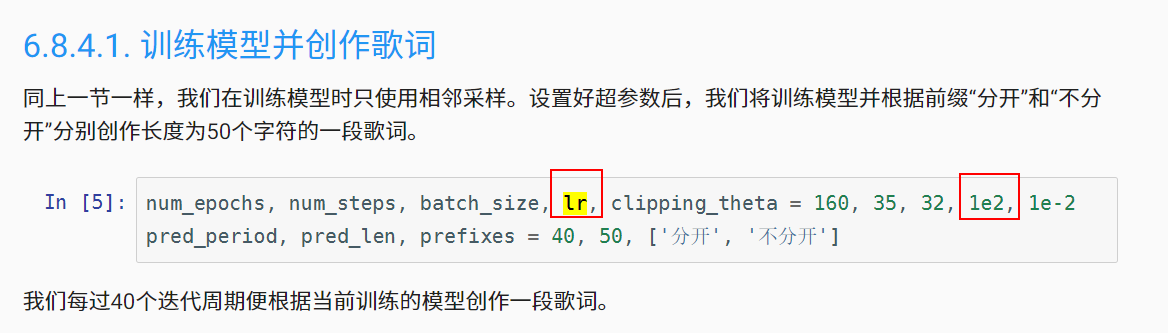

## 小结

* 长短期记忆的隐藏层输出包括隐藏状态和记忆细胞。只有隐藏状态会传递到输出层。
* 长短期记忆的输入门、遗忘门和输出门可以控制信息的流动。
* 长短期记忆可以应对循环神经网络中的梯度衰减问题，并更好地捕捉时间序列中时间步距离较大的依赖关系。



## 参考文献

[1] Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780.

-----------

> 注：除代码外本节与原书此节基本相同，[原书传送门](https://zh.d2l.ai/chapter_recurrent-neural-networks/lstm.html)



**注：居然是1997年就出了，这个好厉害！**